# One-Hot Linear Model (Logistic Regression)

Using the class-balanced data.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the SEQ_LEN by 50%.

In [1]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'one-hot'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

Imports and colab setup

In [2]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb

# For resolving the below issue with Colab and plotly:
# https://stackoverflow.com/questions/69564817/typeerror-load-missing-1-required-positional-argument-loader-in-google-col
!pip install pyyaml==5.4.1

`wandb` log in:

In [3]:
wandb.login()

wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


True

Google drive access

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [5]:
import arxiv_vixra_models as avm

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Set the model, datamodule, and text decoder to be instantianted in the notebook:

In [6]:
notebook_model = avm.LitOneHotFC
notebook_datamodule = avm.OneHotCharDataModuleAV
notebook_encoder = avm.str_to_one_hot 
notebook_decoder = avm.one_hot_to_str 
notebook_wandb_callback = avm.WandbAVPredictionCallback

Copy data to cwd for speed.

In [7]:
train_text_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_text_path = FOLDERNAME + SUBDIR + train_text_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_text_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_text_df = pd.read_feather(train_text_file_name)
val_text_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)
if TEXT_ENCODING == 'one-hot':
    text_to_idx = avm.char_to_idx_dict_from_df(tokens_df)
    idx_to_text = avm.idx_to_char_dict_from_df(tokens_df)
else:
    # 0 and 1 are reserved for padding and <UNK> for embeddings and not included
    # in tokens_df
    text_to_idx = avm.word_to_idx_dict_from_df(tokens_df)
    idx_to_text = avm.idx_to_word_dict_from_df(tokens_df)

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [8]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Thu Jan 27 21:32:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [9]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

balanced_title_linear_one_hot


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [10]:
val_data_intersections_filtered_df = val_text_df.merge(train_text_df, on=[TEXT_FIELD], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_text_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_text_df) - len(val_data_intersections_filtered_df)) / len(val_text_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [11]:
print(train_text_df.head().to_string())

                                                                                                title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [12]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [13]:
model_args_dict = {'seq_len': SEQ_LEN,
                  'tokens_df': tokens_df,
                  'fc_dims': None,
                  'nonlinearity': False,
                   'zero_fc_bias_init': True
                  }
data_args_dict = {'seq_len': SEQ_LEN,
                 'train_text_df': train_text_df,
                 'val_text_df': val_data_intersections_filtered_df,
                 'tokens_df': tokens_df, 
                 'text_column': TEXT_FIELD,
                 'batch_size': 128,
                 'num_workers': NUM_PROCESSORS,
                 'pin_memory': IS_CUDA_AVAILABLE,
                 'persistent_workers': True
                 }

Small test run.

In [16]:
small_data_module = notebook_datamodule(**{**data_args_dict, **{'sample_size': .5}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, idx_to_text).strip()
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**model_args_dict)
print('Model layers:', small_model)
small_preds, small_losses = small_model.get_scores_loss(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', -np.log(.5))

text: a general definition of means and corresponding inequalities
len: 60
source: True
text: inequality in the universe , imaginary numbers and a brief solution to p = np ? problem
len: 87
source: True
text: sufficient conditions for memory kernel master equation
len: 55
source: False
Model layers: LitOneHotFC(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



preds shape: torch.Size([128])

actual loss: 0.7556024789810181

expected approx loss 0.6931471805599453


In [17]:
small_trainer = Trainer(-1 if IS_CUDA_AVAILABLE else 0,
                        max_epochs=1,
                        precision=16,
                        profiler='simple',)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:659: UserWarning: You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU. Using `precision='bf16'` instead.
  "You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU."
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  8.9319         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  6.5539         	|1              	|  6.5539         	|  73.377         	|
run_training_batch                 	|  0.048623       	|100            	|  4.8623         	|  54.437         	|
optimizer_step_with_closure_0      	|  0.04809        	|100            	|  4.809          	|  53.841         	|
training_step_and_backward         	|  0.045657       	|100            	|  4.5657         	|  51.117         	|
model_forward                      

Suggested lr: 5.754399373371569e-06


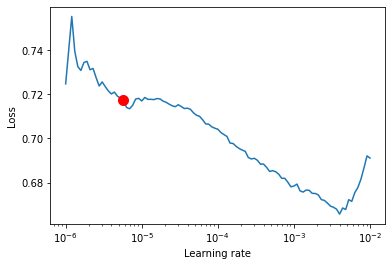

In [18]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module, min_lr=1e-6, max_lr=1e-2)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
small_trainer_suggested_lr = small_trainer_lr_finder.suggestion()
print(f'Suggested lr: {small_trainer_suggested_lr}')

# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `sweep_fixed_model_args_dict`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `sweep_fixed_model_args_dict` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [19]:
sweep_fixed_model_args_dict = {**model_args_dict, **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'min': np.log(1e-4).item(),
                                      'max': np.log(1e-2).item()
                                      },                          
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `sweep_fixed_model_args_dict` for logging purposes.

In [20]:
# Setting 'batch_size' in data_args_dict controls the batch size, while setting
# this key in sweep_fixed_model_args_dict just lets wandb track this hyperparameter.
sweep_data_args_dict = deepcopy(data_args_dict)
sweep_data_args_dict['batch_size'] = sweep_fixed_model_args_dict['batch_size'] = 4096

# Set max_epochs in a dict, along with any other optional trainer kwargs.
sweep_trainer_dict = {'max_epochs': 32,
               }

# Merge sweep_trainer_dict into sweep_fixed_model_args_dict for logging purposes.
sweep_fixed_model_args_dict = {**sweep_fixed_model_args_dict, **sweep_trainer_dict}


def sweep_val_examples(sample_size=512,
                       datamodule_args=sweep_data_args_dict):
    """Taking random samples from the validation set for callback visualization.
    """
    val_sample_module = notebook_datamodule(**{**datamodule_args,
                                               **{'sample_size': sample_size}})
    val_sample_module.setup()
    val_sample  = next(iter(val_sample_module.val_dataloader()))
    return val_sample

def sweep_trainer():
    """Encapsulating the trainer used for wandb sweeps.
    """
    trainer = Trainer(logger=WandbLogger(),
                      gpus=-1 if IS_CUDA_AVAILABLE else 0,
                      log_every_n_steps=5,
                      precision=16,
                      profiler='simple',
                      callbacks=[notebook_wandb_callback(val_sample=sweep_val_examples(),
                                                         decoder_fn=notebook_decoder,
                                                         decoder_dict=idx_to_text,
                                                         labels=('arxiv', 'vixra')),
                                 EarlyStopping(monitor='val_acc',
                                               mode='max',
                                               check_on_train_epoch_end=False,
                                               patience=5,
                                               verbose=True)
                                 ],
                      num_sanity_val_steps=-1,
                      **sweep_trainer_dict
                      )
    return trainer

def sweep_iteration():
    """The wandb sweep iteration function. To be passed to wandb.agent.
    """
    # There seems to be a 128 char limit on the group_str
    group_str = '-'.join(sorted([f'{key}_{val}' for key, val in sweep_fixed_model_args_dict.items() if key != 'tokens']))[:128]
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**sweep_data_args_dict)
        config = wandb.config
        # Overwrite the random run names chosen by wandb.
        run.name = '-'.join(sorted([f'{key}_{val}' for key, val in config.items()]))[:128]
        # Merge config into remaining parameters.
        config = {**sweep_fixed_model_args_dict, **config}
        model = notebook_model(**config)
        print(50 * '-',
              'Model Architecture:',
              model,
              50 * '-',
              sep='\n')
        trainer = sweep_trainer()
        trainer.fit(model, 
                    datamodule=data)

In [21]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: 6iwmf5a8
Sweep URL: https://wandb.ai/garrett361/balanced_title_linear_one_hot/sweeps/6iwmf5a8


In [22]:
wandb.agent(sweep_id, function=sweep_iteration, count=3)
# Sweeps will generate a huge number of plots, if not closed.
plt.close("all")

wandb: Agent Starting Run: c6d993jm with config:
wandb: 	lr: 0.00013268129672984932


--------------------------------------------------
Model Architecture:
LitOneHotFC(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (layers): ModuleList(
    (0): Linear(in_features=8832, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a 

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.48357370495796204
Validation Loss: 0.713873028755188
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.48357370495796204
Validation Loss: 0.713873028755188


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.5723824501037598
Validation Loss: 0.6663781404495239
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.5723824501037598
Validation Loss: 0.6663781404495239


Metric val_acc improved. New best score: 0.572


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6264690160751343
Validation Loss: 0.6458735466003418
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6264690160751343
Validation Loss: 0.6458735466003418


Metric val_acc improved by 0.054 >= min_delta = 0.0. New best score: 0.626


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6372863054275513
Validation Loss: 0.6368842720985413
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6372863054275513
Validation Loss: 0.6368842720985413


Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.637


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6424946784973145
Validation Loss: 0.6304302215576172
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6424946784973145
Validation Loss: 0.6304302215576172


Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.642


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6456997990608215
Validation Loss: 0.6252856254577637
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6456997990608215
Validation Loss: 0.6252856254577637


Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.646


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.6459668874740601
Validation Loss: 0.6202764511108398
Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.6459668874740601
Validation Loss: 0.6202764511108398


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.646


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 62
Epoch: 6
Validation accuracy: 0.6470352411270142
Validation Loss: 0.6164193153381348
Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.6470352411270142
Validation Loss: 0.6164193153381348


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 7
Validation accuracy: 0.6473023295402527
Validation Loss: 0.6129859685897827
Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6473023295402527
Validation Loss: 0.6129859685897827


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 80
Epoch: 8
Validation accuracy: 0.6531783938407898
Validation Loss: 0.6099463701248169
Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.6531783938407898
Validation Loss: 0.6099463701248169


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 9
Validation accuracy: 0.6563835740089417
Validation Loss: 0.6069869995117188
Saved best val_loss at global step: 89
Epoch: 9
Validation accuracy: 0.6563835740089417
Validation Loss: 0.6069869995117188


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 98
Epoch: 10
Validation accuracy: 0.6578525900840759
Validation Loss: 0.6043601632118225
Saved best val_loss at global step: 98
Epoch: 10
Validation accuracy: 0.6578525900840759
Validation Loss: 0.6043601632118225


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 11
Validation accuracy: 0.6599892973899841
Validation Loss: 0.6020304560661316
Saved best val_loss at global step: 107
Epoch: 11
Validation accuracy: 0.6599892973899841
Validation Loss: 0.6020304560661316


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 116
Epoch: 12
Validation accuracy: 0.660523533821106
Validation Loss: 0.599681556224823
Saved best val_loss at global step: 116
Epoch: 12
Validation accuracy: 0.660523533821106
Validation Loss: 0.599681556224823


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 13
Validation accuracy: 0.6626602411270142
Validation Loss: 0.5979675054550171
Saved best val_loss at global step: 125
Epoch: 13
Validation accuracy: 0.6626602411270142
Validation Loss: 0.5979675054550171


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 134
Epoch: 14
Validation accuracy: 0.6626602411270142
Validation Loss: 0.5957149267196655


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 15
Validation accuracy: 0.6642628312110901
Validation Loss: 0.5941465497016907
Saved best val_loss at global step: 143
Epoch: 15
Validation accuracy: 0.6642628312110901
Validation Loss: 0.5941465497016907


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 152
Epoch: 16
Validation accuracy: 0.6682692170143127
Validation Loss: 0.5927437543869019
Saved best val_loss at global step: 152
Epoch: 16
Validation accuracy: 0.6682692170143127
Validation Loss: 0.5927437543869019


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 161
Epoch: 17
Validation accuracy: 0.6673343777656555
Validation Loss: 0.5910057425498962


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 170
Epoch: 18
Validation accuracy: 0.6729433536529541
Validation Loss: 0.5903083086013794
Saved best val_loss at global step: 170
Epoch: 18
Validation accuracy: 0.6729433536529541
Validation Loss: 0.5903083086013794


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 179
Epoch: 19
Validation accuracy: 0.6733440160751343
Validation Loss: 0.5885606408119202
Saved best val_loss at global step: 179
Epoch: 19
Validation accuracy: 0.6733440160751343
Validation Loss: 0.5885606408119202


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 188
Epoch: 20
Validation accuracy: 0.6753472089767456
Validation Loss: 0.5873201489448547
Saved best val_loss at global step: 188
Epoch: 20
Validation accuracy: 0.6753472089767456
Validation Loss: 0.5873201489448547


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 197
Epoch: 21
Validation accuracy: 0.6696047186851501
Validation Loss: 0.5863001346588135


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 206
Epoch: 22
Validation accuracy: 0.6714743375778198
Validation Loss: 0.5851295590400696


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 215
Epoch: 23
Validation accuracy: 0.6801549196243286
Validation Loss: 0.5844671726226807
Saved best val_loss at global step: 215
Epoch: 23
Validation accuracy: 0.6801549196243286
Validation Loss: 0.5844671726226807


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 224
Epoch: 24
Validation accuracy: 0.6838942170143127
Validation Loss: 0.5844224691390991
Saved best val_loss at global step: 224
Epoch: 24
Validation accuracy: 0.6838942170143127
Validation Loss: 0.5844224691390991


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 233
Epoch: 25
Validation accuracy: 0.6790865659713745
Validation Loss: 0.5825611352920532


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 242
Epoch: 26
Validation accuracy: 0.6804220080375671
Validation Loss: 0.5818338394165039


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 251
Epoch: 27
Validation accuracy: 0.6785523295402527
Validation Loss: 0.5809531211853027


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 260
Epoch: 28
Validation accuracy: 0.6818910241127014
Validation Loss: 0.580227255821228


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 269
Epoch: 29
Validation accuracy: 0.6821581125259399
Validation Loss: 0.5795657634735107


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
best_val_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_auroc,▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
train_avg_precision,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
train_epoch_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_f1,▁▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_precision,▁▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
train_recall,▁▄▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█████


wandb: Agent Starting Run: 5qxqkuul with config:
wandb: 	lr: 0.0003512528682887909


--------------------------------------------------
Model Architecture:
LitOneHotFC(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (layers): ModuleList(
    (0): Linear(in_features=8832, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a 

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.49185362458229065
Validation Loss: 0.7089009284973145
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.49185362458229065
Validation Loss: 0.7089009284973145


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6328792572021484
Validation Loss: 0.644946813583374
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6328792572021484
Validation Loss: 0.644946813583374


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6485042572021484
Validation Loss: 0.6306835412979126
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6485042572021484
Validation Loss: 0.6306835412979126


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6510416865348816
Validation Loss: 0.6186676621437073
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6510416865348816
Validation Loss: 0.6186676621437073


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6554487347602844
Validation Loss: 0.6105291843414307
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6554487347602844
Validation Loss: 0.6105291843414307


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6547809839248657
Validation Loss: 0.6035352945327759


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.6678686141967773
Validation Loss: 0.5978705883026123
Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.6678686141967773
Validation Loss: 0.5978705883026123


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 62
Epoch: 6
Validation accuracy: 0.66920405626297
Validation Loss: 0.5933578014373779
Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.66920405626297
Validation Loss: 0.5933578014373779


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 7
Validation accuracy: 0.6776175498962402
Validation Loss: 0.5902869701385498
Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6776175498962402
Validation Loss: 0.5902869701385498


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 80
Epoch: 8
Validation accuracy: 0.6825587749481201
Validation Loss: 0.5876060724258423
Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.6825587749481201
Validation Loss: 0.5876060724258423


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 9
Validation accuracy: 0.6868322491645813
Validation Loss: 0.5859453678131104
Saved best val_loss at global step: 89
Epoch: 9
Validation accuracy: 0.6868322491645813
Validation Loss: 0.5859453678131104


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 98
Epoch: 10
Validation accuracy: 0.6821581125259399
Validation Loss: 0.5826650857925415


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 107
Epoch: 11
Validation accuracy: 0.6770833134651184
Validation Loss: 0.5812867879867554


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 116
Epoch: 12
Validation accuracy: 0.6838942170143127
Validation Loss: 0.5792751312255859


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 13
Validation accuracy: 0.691773533821106
Validation Loss: 0.5793440341949463


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 134
Epoch: 14
Validation accuracy: 0.6935096383094788
Validation Loss: 0.578391432762146
Saved best val_loss at global step: 134
Epoch: 14
Validation accuracy: 0.6935096383094788
Validation Loss: 0.578391432762146


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 143
Epoch: 15
Validation accuracy: 0.6911057829856873
Validation Loss: 0.5760893225669861


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 152
Epoch: 16
Validation accuracy: 0.694978654384613
Validation Loss: 0.5755605101585388
Saved best val_loss at global step: 152
Epoch: 16
Validation accuracy: 0.694978654384613
Validation Loss: 0.5755605101585388


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 161
Epoch: 17
Validation accuracy: 0.6948450803756714
Validation Loss: 0.5748242139816284


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 170
Epoch: 18
Validation accuracy: 0.6941773295402527
Validation Loss: 0.5736221075057983


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 179
Epoch: 19
Validation accuracy: 0.6925747990608215
Validation Loss: 0.573041558265686


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 188
Epoch: 20
Validation accuracy: 0.6967147588729858
Validation Loss: 0.5727622509002686
Saved best val_loss at global step: 188
Epoch: 20
Validation accuracy: 0.6967147588729858
Validation Loss: 0.5727622509002686


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 197
Epoch: 21
Validation accuracy: 0.6980502009391785
Validation Loss: 0.5727149248123169
Saved best val_loss at global step: 197
Epoch: 21
Validation accuracy: 0.6980502009391785
Validation Loss: 0.5727149248123169


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 206
Epoch: 22
Validation accuracy: 0.702590823173523
Validation Loss: 0.5740635395050049


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 215
Epoch: 23
Validation accuracy: 0.7003205418586731
Validation Loss: 0.572112500667572


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 224
Epoch: 24
Validation accuracy: 0.6945779919624329
Validation Loss: 0.5712165832519531


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 242
Epoch: 26
Validation accuracy: 0.6968482732772827
Validation Loss: 0.5708283185958862


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▃▃▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████
best_val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_acc,▁▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
train_auroc,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████████
train_avg_precision,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
train_epoch_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_f1,▁▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████
train_precision,▁▄▅▆▆▇▇▇▇▇▇█████████████████
train_recall,▁▅▅▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇██████


wandb: Agent Starting Run: 5jrlw7ue with config:
wandb: 	lr: 0.00012979274590950657


--------------------------------------------------
Model Architecture:
LitOneHotFC(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (layers): ModuleList(
    (0): Linear(in_features=8832, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a 

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.52857905626297
Validation Loss: 0.6840241551399231
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.52857905626297
Validation Loss: 0.6840241551399231


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6069711446762085
Validation Loss: 0.6542889475822449
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6069711446762085
Validation Loss: 0.6542889475822449


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6262019276618958
Validation Loss: 0.6436216831207275
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6262019276618958
Validation Loss: 0.6436216831207275


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6370192170143127
Validation Loss: 0.6378539204597473
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6370192170143127
Validation Loss: 0.6378539204597473


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6418269276618958
Validation Loss: 0.6325172781944275
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6418269276618958
Validation Loss: 0.6325172781944275


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6399572491645813
Validation Loss: 0.6274630427360535


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.6416933536529541
Validation Loss: 0.6233023405075073


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.6390224099159241
Validation Loss: 0.6195535063743591


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 7
Validation accuracy: 0.6478365659713745
Validation Loss: 0.6160063743591309
Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6478365659713745
Validation Loss: 0.6160063743591309


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.645432710647583
Validation Loss: 0.6125715970993042


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Error in callback <bound method AutoreloadMagics.post_execute_hook of <autoreload.AutoreloadMagics object at 0x7fd59f154cd0>> (for post_execute):


KeyboardInterrupt: ignored

# Inspecting the Best Model

Load in the best model amongst all runs recorded in `wandb` for this notebook.

In [ ]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT)
run_cats = ('best_val_acc', 'name', 'wandb_path', 'timestamp')
runs_sort_cat = 'best_val_acc'
run_state_dict_file_name = 'model_best_val_acc.pt'
run_init_params_file_name = 'model_init_params.pt'

notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if runs_sort_cat in run_json:
        notebook_runs_dict[runs_sort_cat].append(run_json[runs_sort_cat])
        notebook_runs_dict['name'].append(run.name)
        notebook_runs_dict['wandb_path'].append('/'.join(run.path))
        notebook_runs_dict['timestamp'].append(run_json['_timestamp'])
# See top runs:
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by=runs_sort_cat, ascending=False).reset_index(drop=True)
best_model_wandb_path = notebook_runs_df.iloc[0]['wandb_path']
display(notebook_runs_df)
# Write state dict and init params to final models folder.
!cp "{run_state_dict_file_name}" "{FOLDERNAME + '/final_models/' + PROJECT + '_state_dict.pt'}"
!cp "{run_init_params_file_name}" "{FOLDERNAME + '/final_models/' + PROJECT + '_init_params.pt'}"
# Restore best model.
wandb.restore(run_state_dict_file_name, run_path = best_model_wandb_path, replace=True)
wandb.restore(run_init_params_file_name, run_path = best_model_wandb_path, replace=True)
best_model_state_dict = torch.load(run_state_dict_file_name)
best_model_init_params = torch.load(run_init_params_file_name)
best_model = notebook_model(**best_model_init_params)
best_model.load_state_dict(torch.load(run_state_dict_file_name))

,best_val_acc,name,wandb_path,timestamp
0,0.698985,lr_0.0017072100371523615,garrett361/balanced_title_linear_one_hot/4egshk3z,1642559720


cp: cannot stat 'model_best_val_acc.pt': No such file or directory
cp: cannot stat 'model_init_params.pt': No such file or directory


/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: FutureWarning:

The `F1` was deprecated since v0.7 in favor of `torchmetrics.classification.f_beta.F1Score`. It will be removed in v0.8.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



<All keys matched successfully>

Inspect the form of the weight layer, re-shaped to reflect the one-hot encoding again.

In [ ]:
best_model_weights = best_model.fc_layers[0].weight.detach().view(1, -1, len(tokens_df))
best_model_bias = best_model.fc_layers[0].bias.detach()

Check out the weights for the final positions in the sequence, taking the top and bottom 5 values. Create small dataframes with the associated characters and weights.

In [ ]:
best_model_weights_last_topk = best_model_weights[:,-1,:].topk(5, dim=-1)
best_model_weights_last_bottomk = best_model_weights[:,-1,:].topk(5, dim=-1, largest=False)
best_model_weights_last_topk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_last_topk.indices.view(-1)].char.values, 'weight': best_model_weights_last_topk.values.view(-1).detach()})
best_model_weights_last_bottomk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_last_bottomk.indices.view(-1)].char.values, 'weight': best_model_weights_last_bottomk.values.view(-1).detach()})

In [ ]:
best_model_weights_last_topk_df.append(best_model_weights_last_bottomk_df, ignore_index=True)

,char,weight
0,.,0.125317
1,),0.090201
2,t,0.049800
3,w,0.035909
4,h,0.034420
5,$,-0.108167
6,c,-0.064565
7,s,-0.043454
8,3,-0.041091
9,g,-0.038653


Visualizing the above by inspecting examples and computing the probability that a paper is from `arXiv` or `viXra` given that it ends with a certain character and vice versa:

In [ ]:
def visualize_ends_with(char, df, num=5):
    """View num examples from df which end with char and compute related
    conditional probabilities.
    """
    with pd.option_context('display.max_colwidth', SEQ_LEN):
        mask = df[TEXT_FIELD].str.endswith(char)
        filtered_df = df[mask]
        display(filtered_df[[TEXT_FIELD, 'source']].sample(num))
        print(f"P(viXra|{TEXT_FIELD} ends with {char}): {(filtered_df.source == 'vixra').mean()}")
        print(f"P({TEXT_FIELD} ends with {char}|viXra): {(filtered_df.source == 'vixra').sum() / (df.source == 'vixra').sum()}")
        print(50 * '-')
        print(f"P(arXiv|{TEXT_FIELD} ends with {char}): {(filtered_df.source == 'arxiv').mean()}")
        print(f"P({TEXT_FIELD} ends with {char}|arXiv): {(filtered_df.source == 'arxiv').sum() / (df.source == 'arxiv').sum()}")

In [ ]:
visualize_ends_with('!', train_text_df)

,title,source
20032,geoengineering has wrong target !,vixra
31261,a theory of the muon ; explaining the electron ' s embarrassing fat cousin !,vixra
15312,draw the metric !,vixra
16867,stop new fossil fuel projects !,vixra
15277,"the arrow of time , again !",vixra


P(viXra|title ends with !): 0.8928571428571429
P(title ends with !|viXra): 0.0014227989300552046
--------------------------------------------------
P(arXiv|title ends with !): 0.10714285714285714
P(title ends with !|arXiv): 0.00017073587160662456


In [ ]:
visualize_ends_with('$', train_text_df)

,title,source
22912,isometries and binary images of linear block codes over $ z _ 4 + uz _ 4 $ and $ z _ 8 + uz _ 8 $,arxiv
25216,"lofar - bo \ "" otes : properties of high - and low - excitation radio galaxies at $ 0 . 5 < z < 2 . 0 $",arxiv
916,a characterization of involutes and evolutes of a given curve in $ \ mathbb { e } ^ { n } $,arxiv
490,convergence of glauber dynamic on ising - like models with kac interaction to $ \ phi ^ { 2n } _ 2 $,arxiv
26399,metal - insulator transition in nis $ _ { 2 - x } $ se $ _ x $,arxiv


P(viXra|title ends with $): 0.04716981132075472
P(title ends with $|viXra): 0.0005691195720220818
--------------------------------------------------
P(arXiv|title ends with $): 0.9528301886792453
P(title ends with $|arXiv): 0.011496215354846052


In [ ]:
visualize_ends_with('b', train_text_df)

,title,source
456,a cosmology forecast toolkit - - cosmolib,arxiv
11706,the pagerank algorithm : theory & implementation in scilab,vixra
21568,a retrospective analysis of user exposure to ( illicit ) cryptocurrency mining on the web,arxiv
16693,on general formulas for generating sequences of pythagorean triples ordered by c - b,vixra
28401,generation and validation of custom multiplication ip blocks from the web,arxiv


P(viXra|title ends with b): 0.25
P(title ends with b|viXra): 0.0006829434864264982
--------------------------------------------------
P(arXiv|title ends with b): 0.75
P(title ends with b|arXiv): 0.002048830459279495


Same analysis for starting position:

In [ ]:
best_model_weights_first_topk = best_model_weights[:,0,:].topk(5, dim=-1)
best_model_weights_first_bottomk = best_model_weights[:,0,:].topk(5, dim=-1, largest=False)
best_model_weights_first_topk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_first_topk.indices.view(-1)].char.values, 'weight': best_model_weights_first_topk.values.view(-1).detach()})
best_model_weights_first_bottomk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_first_bottomk.indices.view(-1)].char.values, 'weight': best_model_weights_first_bottomk.values.view(-1).detach()})

In [ ]:
best_model_weights_first_topk_df.append(best_model_weights_first_bottomk_df, ignore_index=True)

,char,weight
0,>,0.011600
1,3,0.011246
2,j,0.010937
3,w,0.010714
4,*,0.009604
5,b,-0.016512
6,h,-0.014211
7,m,-0.013670
8,e,-0.012343
9,$,-0.011983


Seemingly all noise since the first position is often padding.

In [ ]:
def visualize_starts_with(char, df, num=5):
    """View num examples from df which start with char and compute related
    conditional probabilities.
    """
    with pd.option_context('display.max_colwidth', SEQ_LEN):
        mask = df[TEXT_FIELD].str.startswith(char)
        filtered_df = df[mask]
        display(filtered_df[[TEXT_FIELD, 'source']].sample(num))
        print(f"P(viXra|{TEXT_FIELD} starts with {char}): {(filtered_df.source == 'vixra').mean()}")
        print(f"P({TEXT_FIELD} starts with {char}|viXra): {(filtered_df.source == 'vixra').sum() / (df.source == 'vixra').sum()}")
        print(50 * '-')
        print(f"P(arXiv|{TEXT_FIELD} starts with {char}): {(filtered_df.source == 'arxiv').mean()}")
        print(f"P({TEXT_FIELD} starts with {char}|arXiv): {(filtered_df.source == 'arxiv').sum() / (df.source == 'arxiv').sum()}")

Similar analysis when averaging over sequence positions.

In [ ]:
best_model_weights_mean_topk = best_model_weights.mean(1).topk(5, dim=-1)
best_model_weights_mean_bottomk = best_model_weights.mean(1).topk(5, dim=-1, largest=False)
best_model_weights_mean_topk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_mean_topk.indices.view(-1)].char.values, 'weight': best_model_weights_mean_topk.values.view(-1).detach()})
best_model_weights_mean_bottomk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_mean_bottomk.indices.view(-1)].char.values, 'weight': best_model_weights_mean_bottomk.values.view(-1).detach()})

In [ ]:
best_model_weights_mean_topk_df.append(best_model_weights_mean_bottomk_df, ignore_index=True)

,char,weight
0,h,0.011540
1,",",0.010625
2,',0.008187
3,v,0.005941
4,e,0.005363
5,-,-0.026241
6,$,-0.014578
7,b,-0.008738
8,r,-0.008181
9,l,-0.007863


Visualize similarly:

In [ ]:
def visualize_means(char, df, num=5):
    """View num examples from df which contain char and compute related
    conditional probabilities.
    """
    with pd.option_context('display.max_colwidth', SEQ_LEN):
        mask = df[TEXT_FIELD].str.contains(char)
        filtered_df = df[mask]
        display(filtered_df[[TEXT_FIELD, 'source']].head(num))
        print(f"P(viXra|{TEXT_FIELD} contains {char[-1]}): {(filtered_df.source == 'vixra').mean()}")
        print(f"P({TEXT_FIELD} contains {char[-1]}|viXra): {(filtered_df.source == 'vixra').sum() / (df.source == 'vixra').sum()}")
        print(50 * '-')
        print(f"P(arXiv|{TEXT_FIELD} contains {char[-1]}): {(filtered_df.source == 'arxiv').mean()}")
        print(f"P({TEXT_FIELD} contains {char[-1]}|arXiv): {(filtered_df.source == 'arxiv').sum() / (df.source == 'arxiv').sum()}")

In [ ]:
visualize_means('\$', train_text_df)

,title,source
50,subpicosecond $ x $ rotations of atomic clock states,arxiv
67,"classes and equivalence of linear sets in $ pg ( 1 , q ^ n ) $",arxiv
224,weak sequential completeness in banach $ c ( k ) $ - modules of finite multiplicity,arxiv
304,competition of three - dimensional magnetic phases in ca $ _ 2 $ ru $ _ { 1 - x } $ fe $ _ x $ o $ _ 4 $ : a structural pers...,arxiv
490,convergence of glauber dynamic on ising - like models with kac interaction to $ \ phi ^ { 2n } _ 2 $,arxiv


P(viXra|title contains $): 0.044543429844097995
P(title contains $|viXra): 0.0022764782880883272
--------------------------------------------------
P(arXiv|title contains $): 0.955456570155902
P(title contains $|arXiv): 0.04883045927949462


In [ ]:
visualize_means('\-', train_text_df)

,title,source
3,atomic - scale erector,vixra
4,temperature dependence of microwave and thz dielectric response in srn + 1tino3n + 1 ( n = 1 - 4 ),arxiv
7,certain axion - like particles excluded,vixra
11,a cryogenic amplifier for fast real - time detection of single - electron tunneling,arxiv
14,long time existence and bounded scalar curvature in the ricci - harmonic flow,arxiv


P(viXra|title contains -): 0.3276078010377527
P(title contains -|viXra): 0.20841158727448636
--------------------------------------------------
P(arXiv|title contains -): 0.6723921989622472
P(title contains -|arXiv): 0.4277502703317967


In [ ]:
visualize_means('\'', train_text_df)

,title,source
17,the nineteen postulates of einstein ' s special relativity theory,vixra
29,a very exhaustive generalization of de polignac ' s conjecture,vixra
30,thiele ' s differential equation based on markov jump processes with non - countable state space,arxiv
32,extending fourier transformations to hamilton ' s quaternions and clifford ' s geometric algebras,vixra
70,"on a single page , beal conjecture ; equivalent beal conjecture & fermat ' s last theorem proved",vixra


P(viXra|title contains '): 0.6973255055446836
P(title contains '|viXra): 0.06083888224916055
--------------------------------------------------
P(arXiv|title contains '): 0.30267449445531636
P(title contains '|arXiv): 0.0264071481418246


In [ ]:
visualize_means('\_', train_text_df)

,title,source
94,"q _ r - conformal symmetries in 2d nonlocal quantum field theory , categorical representation theory , and virasoro algebra",arxiv
133,can old galaxies at high redshifts and baryon acoustic oscillations constrain h _ 0 ?,arxiv
304,competition of three - dimensional magnetic phases in ca $ _ 2 $ ru $ _ { 1 - x } $ fe $ _ x $ o $ _ 4 $ : a structural pers...,arxiv
425,electronic structure and charge - density wave transition in monolayer vs _ { 2 },arxiv
490,convergence of glauber dynamic on ising - like models with kac interaction to $ \ phi ^ { 2n } _ 2 $,arxiv


P(viXra|title contains _): 0.09292929292929293
P(title contains _|viXra): 0.0026179500313015763
--------------------------------------------------
P(arXiv|title contains _): 0.907070707070707
P(title contains _|arXiv): 0.025553468783791475


Can also look at positional dependence by taking the `mean` over the character dimension

In [ ]:
# Positions most informative of viXra.
best_model_weights.mean(-1).topk(5, dim=-1)

torch.return_types.topk(values=tensor([[0.0026, 0.0023, 0.0021, 0.0020, 0.0017]]), indices=tensor([[ 41,  48, 127,  18, 122]]))

In [ ]:
# Positions most informative of arXiv.
best_model_weights.mean(-1).topk(5, dim=-1, largest=False)

torch.return_types.topk(values=tensor([[-0.0045, -0.0041, -0.0038, -0.0038, -0.0036]]), indices=tensor([[58, 94, 77, 91, 96]]))

In [ ]:
# Overall most informative positions.
best_model_weights.mean(-1).abs().topk(5, dim=-1)

torch.return_types.topk(values=tensor([[0.0045, 0.0041, 0.0038, 0.0038, 0.0036]]), indices=tensor([[58, 94, 77, 91, 96]]))

So the more informative positions tend to be those towards the end of the sequence, which makes sense given the padding.

We also expect blank spaces to be somewhat informative of viXra titles, which tend to be shorter (since blank spaces were used as padding).  Plot the weights associated with blank space by sequence position along with their cumulatitve sum. Also indicate the mean start positions of arXiv and viXra titles

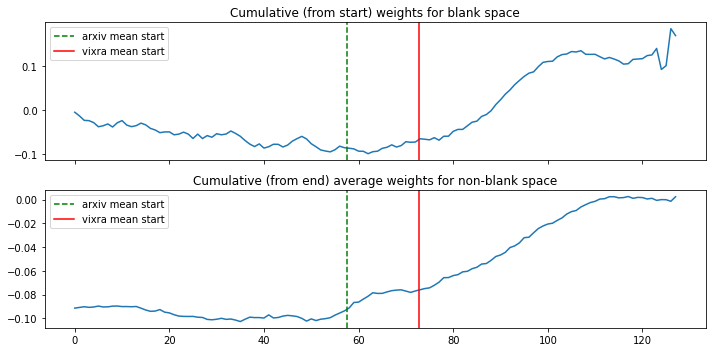

In [ ]:
arxiv_mean_start = SEQ_LEN - train_text_df[train_text_df['source'] == 'arxiv']['title'].str.len().mean()
vixra_mean_start = SEQ_LEN - train_text_df[train_text_df['source'] == 'vixra']['title'].str.len().mean()
fig, axs = plt.subplots(2,1, figsize=(10, 5), sharex=True)
axs[0].plot(np.arange(128), [best_model_weights[0,:n + 1,0].detach().sum() for n in range(128)])
axs[1].plot(np.arange(128), [best_model_weights[0,n:,1:].detach().mean(dim=-1).sum() for n in range(128)])
axs[0].set_title('Cumulative (from start) weights for blank space')
axs[1].set_title('Cumulative (from end) average weights for non-blank space')
for ax in axs:
    ax.axvline(x=arxiv_mean_start, color='green', linestyle='--', label='arxiv mean start')
    ax.axvline(x=vixra_mean_start, color='red', linestyle='-', label='vixra mean start')
    ax.legend()
plt.tight_layout()
fig.savefig(FOLDERNAME + f'/figures/{PROJECT}_cumulative_weights_by_position.svg', bbox_inches='tight')

# My Papers

Finally, examine the model's results on my own papers:

In [ ]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
goon_papers_df

,title,source
0,"quantum corrections to generic branes : dbi , ...",arxiv
1,universal relation between corrections to entr...,arxiv
2,primordial non - gaussianity,arxiv
3,"superluminality , black holes and eft",arxiv
4,shapes of gravity : tensor non - gaussianity a...,arxiv
5,the effective theory of shift - symmetric cosm...,arxiv
6,partially massless fields during inflation,arxiv
7,soft theorems for shift - symmetric cosmologies,arxiv
8,heavy fields and gravity,arxiv
9,aspects of galileon non - renormalization,arxiv


One-hot encode titles, stack into a tensor, and generate predictions:

In [ ]:
goon_papers_t = torch.stack([tensor for tensor in goon_papers_df[TEXT_FIELD].apply(lambda x: notebook_encoder(x, text_to_idx, SEQ_LEN))], dim=0)
goon_papers_probs_t = best_model.get_probs(goon_papers_t)

According to this model, my titles are nearly as likely to be from vixra as arxiv:

In [ ]:
print(f'Mean prediction: {goon_papers_probs_t.mean().item()}')
print(f'Correct predictions {(goon_papers_probs_t < .5).sum()}/{goon_papers_t.shape[0]}')

Mean prediction: 0.4412439465522766
Correct predictions 10/20


In [ ]:
goon_papers_df['vixra_prob'] = goon_papers_probs_t
goon_papers_sorted_df = goon_papers_df.sort_values(by='vixra_prob', ascending=False).reset_index(drop=True)
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_sorted_df)

,title,source,vixra_prob
0,heavy fields and gravity,arxiv,0.862305
1,"quantum corrections to generic branes : dbi , nlsm , and more",arxiv,0.734948
2,primordial non - gaussianity,arxiv,0.695022
3,gauged galileons from branes,arxiv,0.664706
4,galileons as wess - zumino terms,arxiv,0.649900
5,the effective theory of shift - symmetric cosmologies,arxiv,0.590190
6,partially massless fields during inflation,arxiv,0.578438
7,massive gravity coupled to galileons is ghost - free,arxiv,0.552562
8,aspects of galileon non - renormalization,arxiv,0.549005
9,"superluminality , black holes and eft",arxiv,0.532136


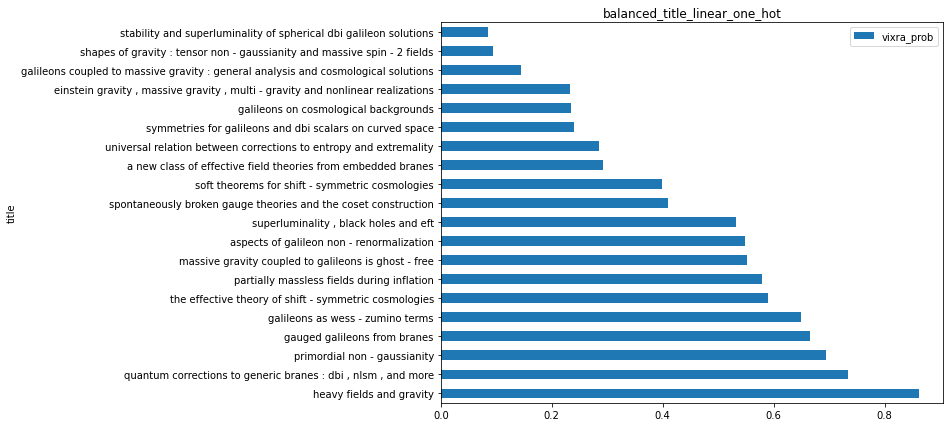

In [ ]:
goon_papers_sorted_df_barh = goon_papers_sorted_df.plot.barh(x='title', y='vixra_prob', title=PROJECT, figsize=(9, 7))
goon_papers_sorted_df_barh.figure.savefig(FOLDERNAME + f'/figures/{PROJECT}_goon_papers_preds.svg', bbox_inches='tight')